In [50]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from mp_api.client import MPRester

from pymatgen.core import Composition, Element
from pymatgen.analysis.phase_diagram import GrandPotentialPhaseDiagram, PhaseDiagram, PDPlotter
from pymatgen.analysis.interface_reactions import InterfacialReactivity, GrandPotentialInterfacialReactivity
from pymatgen.io.vasp import Vasprun
from pymatgen.entries.compatibility import MaterialsProject2020Compatibility
from pymatgen.entries.computed_entries import ComputedEntry
from collections import defaultdict

import re
import sympy as sp




In [51]:
import contextlib
import io, sys
import siman  # program package to manage DFT calculations https://github.com/dimonaks/siman
from siman.calc_manage import smart_structure_read, get_structure_from_matproj
from siman.calc_manage import add, res
from siman import header
from siman.database import write_database, read_database
from siman.set_functions import read_vasp_sets
from siman.header import db
from siman.header import _update_configuration
from pydoc import importfile
from siman import thermo
from matplotlib import rc
import matplotlib.pyplot as plt

# Suppress output (replaces %%capture)
with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
    # Update configurations
    _update_configuration('./project_conf.py')
    read_database()  # read saved database if available
    
    project_sets = importfile('./project_sets.py')
    varset = read_vasp_sets(project_sets.user_vasp_sets, override_global=1)  # read user sets

    # Set paths
    # header.PATH2PROJECT = '../dft_calculations/'
    header.PATH2EDITOR = 'notepad.exe'
    header.PATH2POTENTIALS = "/home/a.burov/soft/vasp_potentials/potpaw_PBE_MPIE/"

    # Matplotlib settings (commented out as they're for interactive use)
    plt.rcParams['figure.dpi'] = 450

In [52]:
api_key = 'HbSHn48X1CSvBzRa4DOX5E9rhb5Tcc03'

In [4]:
def create_dataframe_from_calc(vasprun_path: str, calc_name: str, if_save: bool) -> None:
    """
        Inputs:
            vasprun_path - path to vasprun.xml
            calc_name - name to save a file
            if_save - save pandas dataframe as csv
        Returns:
            pandasDataframe - dataframe with the results
    """

    # Extraction of the calculation
    vasprun = Vasprun(vasprun_path)    
    # include structure so proper correction can be applied for oxides and sulfides
    reactant2 = vasprun.get_computed_entry(inc_structure=True)
    # reactant2.parameters['run_type'] = 'GGA+U'
    
    compatibility = MaterialsProject2020Compatibility()
    # compatibility.process_entry(reactant2)
    reactant2 = compatibility.process_entry(reactant2)

    reactant2.parameters['run_type'] = 'GGA_GGA+U'
    # reactant2.parameters['run_type'] = 'GGA+U'
    # reactant2.parameters['run_type'] = 'GGA+U'

    # Find coatings 
    comps = []
    emins = []
    reactions = []
    
    with MPRester(api_key=api_key) as mpr:
        for comp in tqdm(cathode_coatings.formula_pretty.unique()):
            try:
                # Is the system open to an elemental reservoir?
                grand = False
    
                if grand:
                    # Element in the elemental reservoir.
                    open_el = "Na" 
                    # Relative chemical potential vs. pure substance. Must be non-positive.
                    relative_mu = 3.25 # average intercalation potential
    
    
                # Get the compositions of the reactants
                reactant1 = comp
    
                comp1 = Composition(reactant1)
                comp2 = reactant2.composition # as it is manually calculated phase
    
                # Gather all elements involved in the chemical system.
                # elements = [e.symbol for e in comp1.elements + comp2.elements]
                elements = [e.symbol for e in comp1.elements + comp2.elements]
                
                if grand:
                    elements.append(open_el)
                elements = list(set(elements))  # Remove duplicates
    
                entries = mpr.get_entries_in_chemsys(elements, additional_criteria={'thermo_types': ['GGA_GGA+U', "R2SCAN"]})

                # Apply corrections locally with the mixing scheme
                scheme = MaterialsProjectDFTMixingScheme()
                corrected_entries = scheme.process_entries(entries)
    
                # Build a phase diagram using these entries.
                phase_diagram = PhaseDiagram(entries)
    
                # For an open system, include the grand potential phase diagram.
                if grand:
                    # Get the chemical potential of the pure subtance.
                    mu = phase_diagram.get_transition_chempots(Element(open_el))[0]
                    # Set the chemical potential in the elemental reservoir.
                    chempots = {open_el: relative_mu + mu}
                    # Build the grand potential phase diagram
                    gpd = GrandPotentialPhaseDiagram(entries, chempots)
                    # Create InterfacialReactivity object.
                    interface = GrandPotentialInterfacialReactivity(
                        comp1,
                        comp2,
                        gpd,
                        norm=True,
                        # include_no_mixing_energy=True,
                        include_no_mixing_energy=False,
                        pd_non_grand=phase_diagram,
                        use_hull_energy=True,
                    )
                    
                else:
                    interface = InterfacialReactivity(
                        comp1,
                        comp2,
                        phase_diagram,
                        norm=True,
                        include_no_mixing_energy=False,
                        # include_no_mixing_energy=False,
                        pd_non_grand=None,
                        use_hull_energy=True,
                    )
                    
                interface_table = interface.get_dataframe()
                emins.append(interface.get_dataframe()['E$_{\textrm{rxn}}$ (eV/atom)'].min())
                comps.append(comp)
                index = np.argmin(interface_table['E$_{\textrm{rxn}}$ (eV/atom)'].values)
                reactions.append(interface_table['Reaction'].iloc[index])
            except:
                continue

    res = pd.DataFrame()
    res['formula_pretty'] = comps
    res[f'e_rxn_{calc_name}_CC'] = emins
    res[f'interface_reaction_{calc_name}'] = reactions

    if if_save:
        res.merge(cathode_coatings).round(3).to_csv(f'data_nmc/{calc_name}_CC_calculation_results.csv', index = False)
        
    return res
    
    
    


In [5]:
# Path to vasprun.xml file
vasprun_path = "/home/arseniy/Desktop/work/nvpf_al_doped/data/stability/vasprun_inter.xml"



In [ ]:
# Parse vasprun.xml
vasprun = Vasprun(vasprun_path)

# Get final energy
final_energy = vasprun.final_energy
print(f"Final energy: {final_energy} eV")


In [ ]:
vasprun.final_structure.num_sites

## DOS

In [ ]:
# Access the structure
structure = vasprun.final_structure
# print(structure)

# Access density of states (DOS) if included
dos = vasprun.complete_dos
print(dos)

## Thermodynamic stability

In [6]:
from pymatgen.entries.compatibility import MaterialsProjectCompatibility


In [7]:
def parse_formula(formula):
    pattern = r'([A-Z][a-z]?)(\d*)|(\()|(\))(\d*)'
    matches = list(re.finditer(pattern, formula))
    
    stack = [defaultdict(int)]
    
    for match in matches:
        element, count, open_paren, close_paren, paren_count = match.groups()
        
        if element:
            cnt = int(count) if count else 1
            stack[-1][element] += cnt
        
        elif open_paren:
            stack.append(defaultdict(int))
        
        elif close_paren:
            cnt = int(paren_count) if paren_count else 1
            group = stack.pop()
            for elem, num in group.items():
                stack[-1][elem] += num * cnt
    
    return dict(stack.pop())




In [152]:
# Path to vasprun.xml file
# vasprun_path = "/home/arseniy/Desktop/work/nvpf_al_doped/data/stability/vasprun_inter.xml"
# vasprun_path = "/home/arseniy/Desktop/work/nvpf_al_doped/data/stability/vasprun_deinter.xml"
# vasprun_path = "/home/arseniy/Desktop/work/nvpf_al_doped/data/stability/vasprun_some_na.xml"

# vasprun_path = "/home/arseniy/Desktop/work/nvpf_al_doped/data/stability/vasprun_al.xml"
# vasprun_path = "/home/arseniy/Desktop/work/nvpf_al_doped/data/stability/vasprun_al_some_na.xml"
# vasprun_path = "/home/arseniy/Desktop/work/nvpf_al_doped/data/stability/vasprun_al_some_na_dead.xml"

vasprun_path = "/home/arseniy/Desktop/work/nvpf_al_doped/data/stability/vasprun_al_some_na_dead.xml"



In [153]:
# Parse vasprun.xml
vasprun = Vasprun(vasprun_path)

# Get final energy
final_energy = vasprun.final_energy
print(f"Final energy: {final_energy} eV")


Final energy: -851.87798644 eV eV


In [154]:
comp_entry = ComputedEntry(vasprun.final_structure.composition, vasprun.final_energy)


In [155]:
elements = [el.symbol for el in comp_entry.elements]  # elements in your compound

with MPRester(api_key) as mpr:
    entries = mpr.get_entries_in_chemsys(elements)  # all known phases in this system

    

Retrieving ThermoDoc documents:   0%|          | 0/1365 [00:00<?, ?it/s]

In [156]:
compat = MaterialsProjectCompatibility()
# MaterialsProject2020Compatibility
entries = compat.process_entries(entries)

# Also process your entry with the same corrections
# entry = compat.process_entry(comp_entry)


/tmp/ipykernel_316367/992659018.py:1: DeprecationWarning: MaterialsProjectCompatibility is deprecated; use MaterialsProject2020Compatibility instead.
Materials Project formation energies use the newer MaterialsProject2020Compatibility scheme.
  compat = MaterialsProjectCompatibility()


In [157]:
def balance_reaction_one_reactant_any_products(reactants, products):
    # Get the single reactant name and atom counts
    reactant_name = next(iter(reactants))
    reactant_counts = reactants[reactant_name]

    # Collect unique elements from reactant and all products
    elements = sorted(set(reactant_counts.keys()).union(
        el for p in products.values() for el in p.keys()
    ))

    # Create sympy variables: one for reactant 'a' and one for each product
    a = sp.symbols('a')
    product_vars = sp.symbols(f'b0:{len(products)}')

    # Build balance equations for each element
    equations = []
    for el in elements:
        lhs = a * reactant_counts.get(el, 0)  # reactant side
        rhs = sum(product_vars[i] * p.get(el, 0) for i, p in enumerate(products.values()))
        equations.append(sp.Eq(lhs, rhs))

    # Solve for product coefficients in terms of 'a'
    vars_to_solve = list(product_vars)
    solutions = sp.solve(equations, vars_to_solve, dict=True)
    if not solutions:
        raise ValueError("No solution found to balance the equation.")
    sol = solutions[0]
    sol[a] = a  # keep 'a' free

    # Substitute a=1 to get numeric coefficients
    coeffs = {a: 1}
    coeffs.update({var: sol[var].subs(a, 1) for var in product_vars})

    # Normalize coefficients to smallest integers
    def to_int_fraction(x):
        if isinstance(x, int):
            return x, 1
        else:
            p, q = x.as_numer_denom()
            return int(p), int(q)

    nums_dens = [to_int_fraction(v) for v in coeffs.values()]
    from math import gcd
    from functools import reduce

    def lcm(x, y):
        return x * y // gcd(x, y)

    common_den = reduce(lcm, (d for _, d in nums_dens), 1)
    scaled = [n * (common_den // d) for n, d in nums_dens]
    gcd_all = reduce(gcd, scaled)
    normalized = [s // gcd_all for s in scaled]

    # Prepare output dictionary with species names and their coefficients
    balanced_coeffs = {reactant_name: normalized[0]}
    for i, pname in enumerate(products):
        balanced_coeffs[pname] = normalized[i + 1]

    return balanced_coeffs



In [158]:
st_names = {
        "mp-1238774": 'navpo4f',
        # "mp-25440": 'vpo4f',     
        "mp-686540": 'na3al2p2o8f3',     
        "mp-7848": 'alpo4',     
        "mp-19291": 'navpo5',     
        "mp-468": 'alf3',     
        "mp-559931": 'vf3',     
        "mp-1094113": 'NaV2P2O9',     
        "mp-1104878": 'VPO4F',     
        "mp-17999": 'NaVF4',     
        "mp-752810": 'NaVP2O7',     
        "mp-694937": 'Na3V2P2O8F3',     
        "mp-18835": 'VPO4',     
        "mp-25265": 'VPO5',     
        "mp-26728": 'VP2O7',     
        "mp-1102077": 'NaAlF4',     
       }


In [159]:
all_entries = entries + [comp_entry]
pd = PhaseDiagram(all_entries)

decomp, e_above_hull = pd.get_decomp_and_e_above_hull(comp_entry)

reactants = {vasprun.final_structure.reduced_formula: parse_formula(vasprun.final_structure.reduced_formula)}
reactant_name = next(iter(reactants))
reactant_at = sum(reactants[reactant_name].values())

products = {}

print(f"Energy above hull: {e_above_hull:.4f} eV/atom")
if e_above_hull == 0:
    print("Phase is thermodynamically stable")
elif e_above_hull < 0.05:
    print("Phase is metastable")
else:
    print("Phase decomposes to:")
    for entry, amount in decomp.items():
        mp_id = getattr(entry, "entry_id", "N/A")
        products[entry.composition.reduced_formula] = parse_formula(entry.composition.reduced_formula)
        print(f"{amount:.3f}*{entry.composition.reduced_formula} + ", end="")

    bal = balance_reaction_one_reactant_any_products(reactants, products)
    
    print()
    coeff_react = bal[reactant_name]
    en_decomp = (vasprun.final_energy / vasprun.final_structure.num_sites) * reactant_at * coeff_react
    for entry, amount in decomp.items():
        mp_id = getattr(entry, "entry_id", "N/A")
        mp_id_parse = mp_id.split('-GGA')[0]
        react_name = entry.composition.reduced_formula
        coeff_prod = bal[react_name]
        name_calc = st_names[mp_id_parse]
        en_react = db[name_calc, '9_bulk_mp', 1].e0_at
        product_at = sum(products[entry.composition.reduced_formula].values())
        en_decomp -= en_react * product_at * coeff_prod

    en_decomp /= (reactant_at * coeff_react)
    # en_decomp /= (reactant_at)
    
    print(f"Decomposition energy is {en_decomp*1000:.0f} meV/atom")

        # print(f"  {entry.composition.reduced_formula} (MP-ID: {mp_id}) : {amount:.3f}")
        

Energy above hull: 0.3223 eV/atom
Phase decomposes to:
0.241*NaV2P2O9 + 0.483*VPO4F + 0.172*VP2O7 + 0.103*NaAlF4 + 
Decomposition energy is 3 meV/atom


In [160]:
coeff_react

1

In [161]:
bal


{'Na2AlV7P8(O4F)8': 1, 'NaV2P2O9': 1, 'VPO4F': 4, 'VP2O7': 1, 'NaAlF4': 1}

# Total pDOS on species

In [12]:
from pymatgen.io.vasp import Vasprun
import numpy as np



In [1]:
dos_file_al = "/home/arseniy/Desktop/work/nvpf_al_doped/data/dos/al_dist.xml"

In [4]:
# Load vasprun.xml (path to your file)
vasprun = Vasprun(dos_file_al, parse_projected_eigen=True)

/home/arseniy/micromamba/envs/default/lib/python3.12/site-packages/pymatgen/io/vasp/outputs.py:1256: UserWarning: No POTCAR file with matching TITEL fields was found in

  if potcar := self.get_potcars(path):
/home/arseniy/micromamba/envs/default/lib/python3.12/site-packages/pymatgen/io/vasp/outputs.py:1274: UserWarning: No POTCAR file with matching TITEL fields was found in

  potcar = self.get_potcars(path)


In [6]:
# Get the total and projected dos
cdos = vasprun.complete_dos  # CompleteDos object



In [7]:
# Energies relative to Fermi level
energies = cdos.energies - vasprun.efermi


In [9]:
# Filter V atoms indices
structure = vasprun.final_structure 
v_indices = [i for i, site in enumerate(structure) if site.specie.symbol == 'V']

In [13]:
# Sum the projected DOS on all V atoms
total_dos_v = np.zeros_like(energies)

In [48]:
total_dos_v = np.zeros_like(energies, dtype=float)

for i in v_indices:
    site_pdos = cdos.get_site_dos(structure[i])  # Returns a dict: orbital -> Dos

    # Sum over all orbitals to get total site DOS
    # Each value in site_pdos is a Dos object with densities attribute (array)
    site_total = np.zeros_like(energies, dtype=float)
    for dos_orbital in site_pdos.get_densities():
        site_total += dos_orbital

    total_dos_v += site_total
    

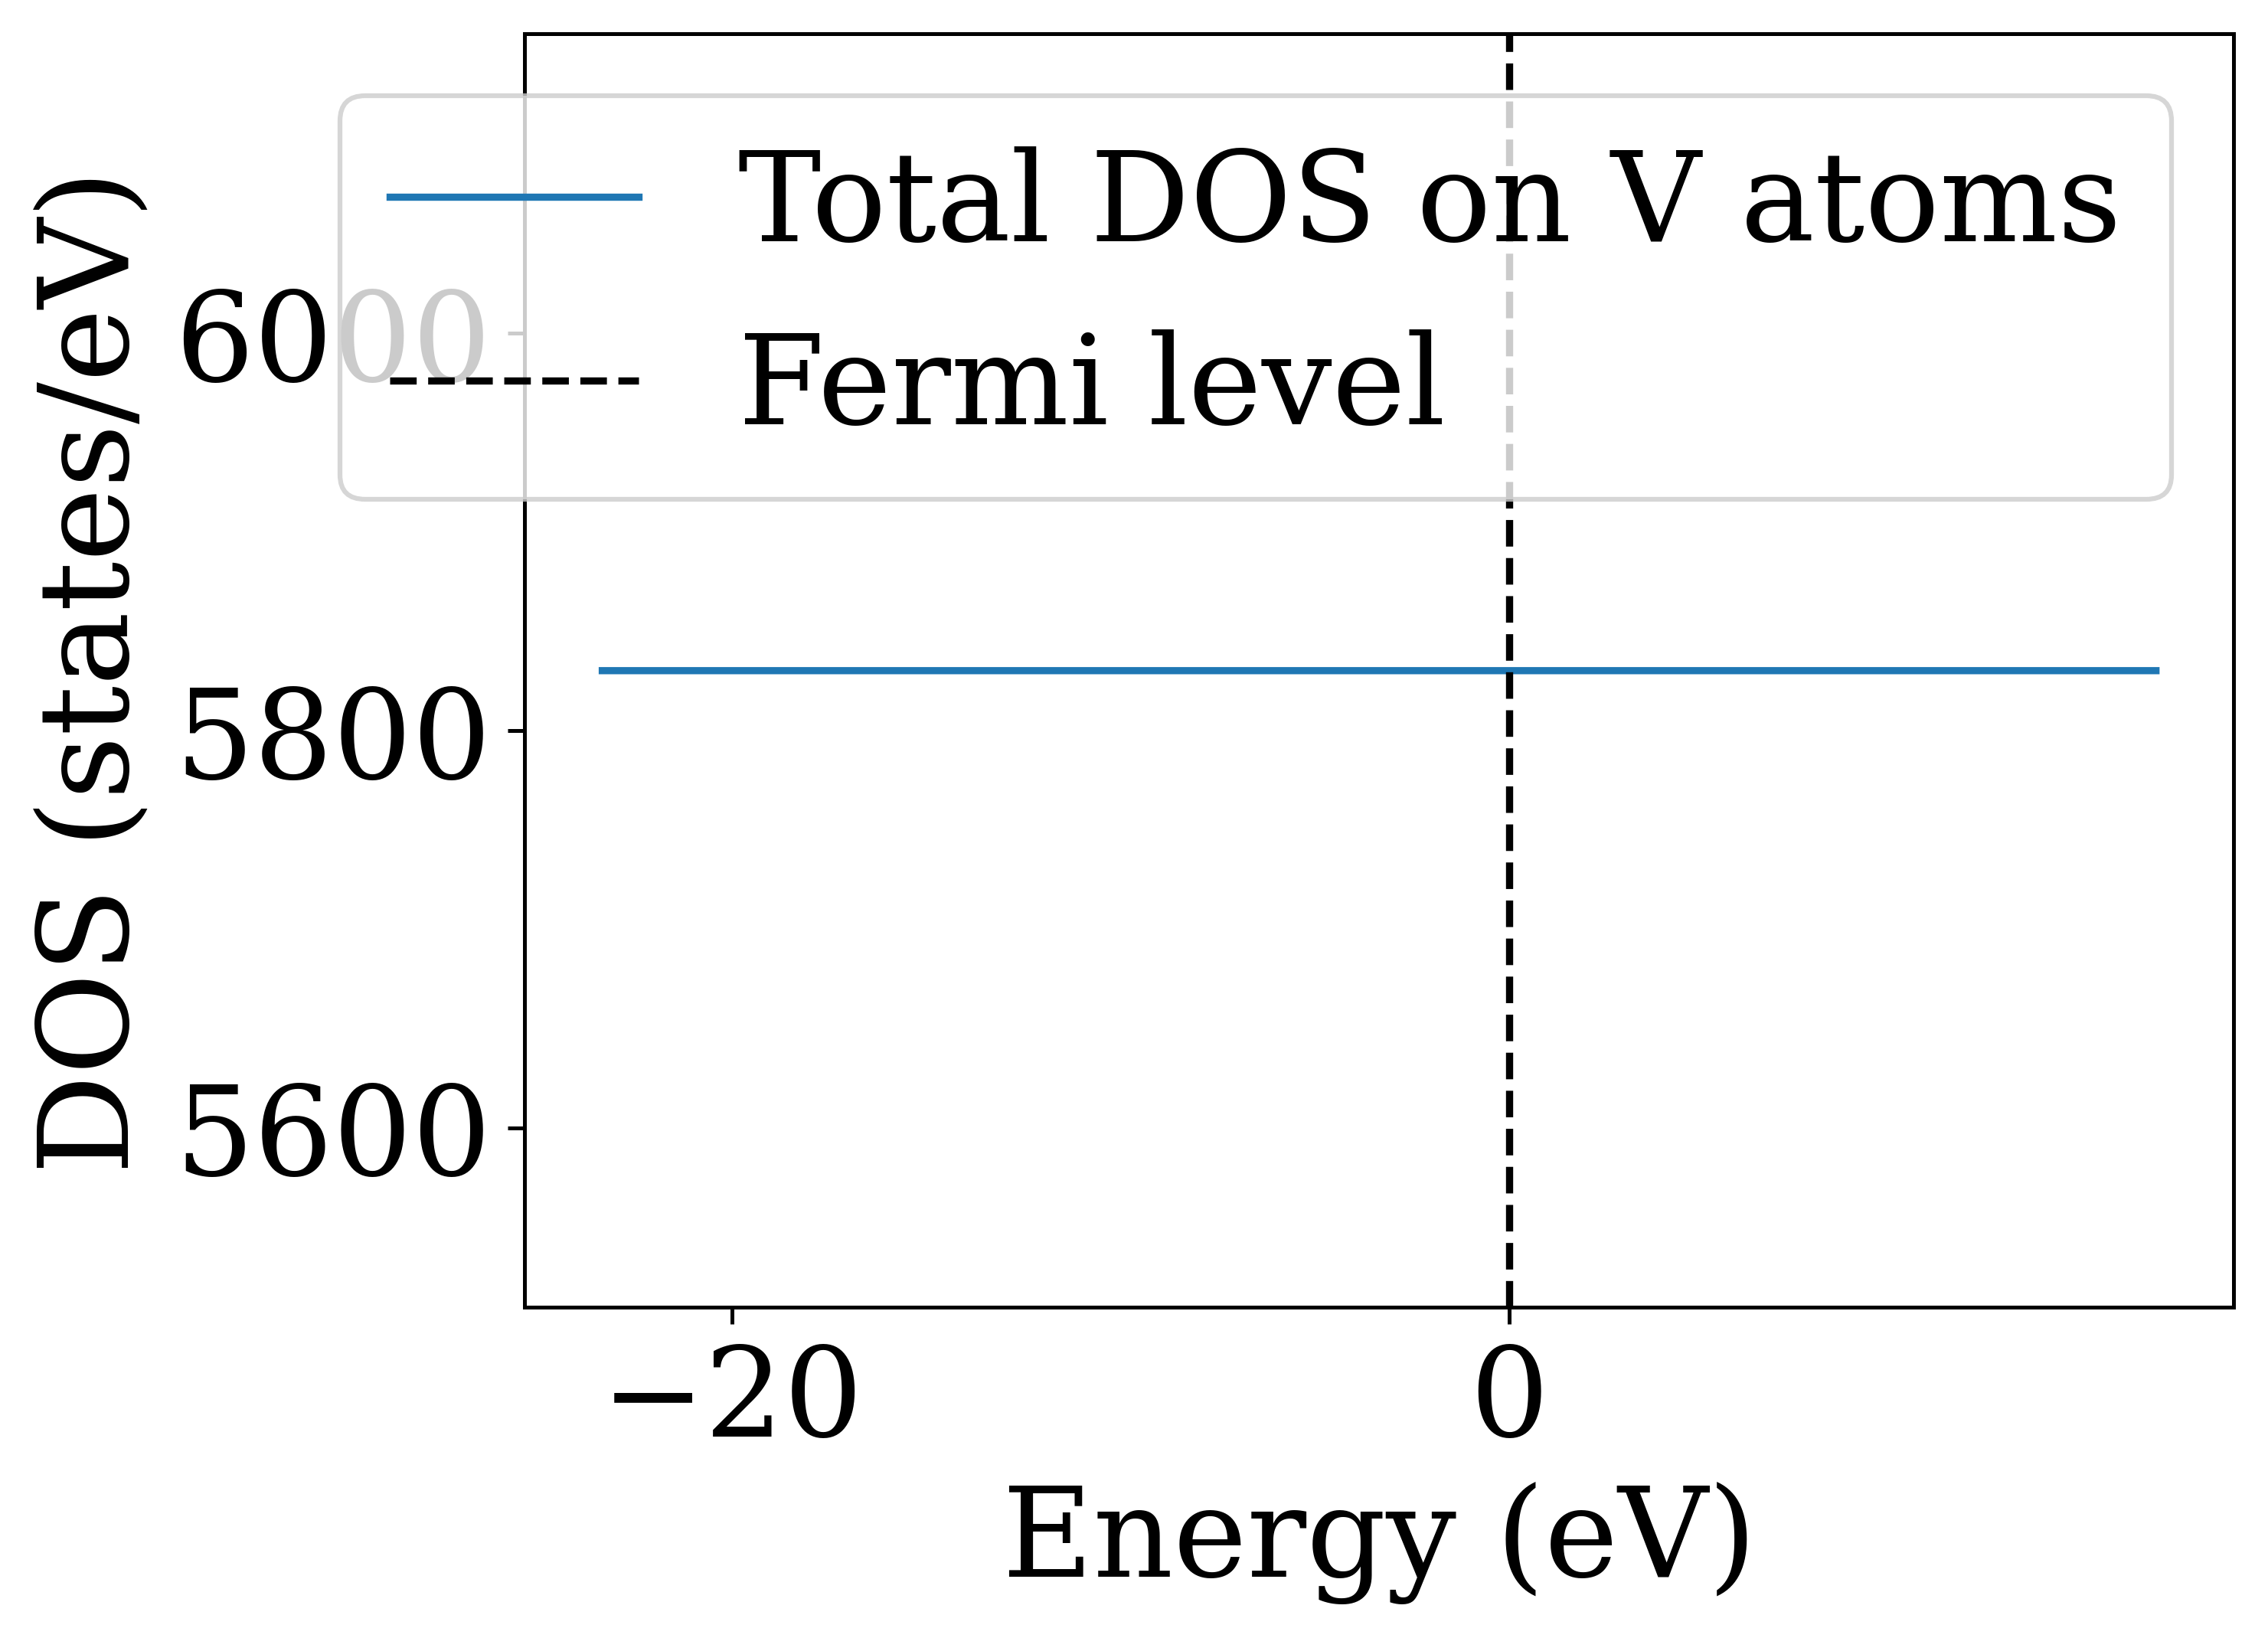

In [53]:
plt.plot(energies, total_dos_v, label='Total DOS on V atoms')
plt.axvline(0, color='k', linestyle='--', label='Fermi level')
plt.xlabel('Energy (eV)')
plt.ylabel('DOS (states/eV)')
plt.legend()
plt.show()



## Total DOS with SUMO package


In [33]:
from sumo.electronic_structure.dos import get_pdos, load_dos



In [26]:
dos_file_al = "/home/arseniy/Desktop/work/nvpf_al_doped/data/dos/al_dist.xml"

In [41]:
vasprun = Vasprun(dos_file_al)
cdos = vasprun.complete_dos
structure = vasprun.final_structure



In [39]:
# dos = load_dos(
#     vasprun,
#     elements={'V': {}},
#     # lm_orbitals=None,
#     # atoms=None,
#     # gaussian=None,
#     # total_only=False,
#     # log=False,
#     # adjust_fermi=True,
#     # scissor=None,
# )



In [42]:
# Get pdos_dict for Vanadium atoms (elements parameter expects a list of element symbols)
# def get_pdos(dos, lm_orbitals=None, atoms=None, elements=None):

pdos_dict = get_pdos(dos=cdos,
                     elements={'V': {}}  
                    )

# energies = cdos.energies - vasprun.efermi


In [43]:
# Plot total DOS projected on V (sum all orbitals)
total_dos_v = None

for dos in pdos_dict.values():
    if total_dos_v is None:
        total_dos_v = dos.densities.copy()
    else:
        total_dos_v += dos.densities


AttributeError: 'dict' object has no attribute 'densities'